In [2]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from time import process_time

np.random.seed(1234)

In [3]:
drop = ['duration',
    'radiant_win',
    'tower_status_radiant',
    'tower_status_dire',
    'barracks_status_dire',
    'barracks_status_radiant']
drop_categorical = [
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero'
]

tar = 'radiant_win'

data_train = pd.read_csv('./features.csv', index_col='match_id')
test = pd.read_csv('features_test.csv', index_col='match_id')

features = data_train.drop(labels=drop, axis = 1)
features_without_categorical = features.drop(labels = drop_categorical, axis = 1)
y = data_train[tar]

missing_features = features.columns[(features.count()<97230).values]
missing_features_test = test.columns[(test.count()<17177).values]
missing_features_test == missing_features

for mf in missing_features_test:
    test[mf] = test[mf].fillna(test[mf].mean())
    features[mf] = features[mf].fillna(features[mf].mean())

In [4]:
def transFORM(x, to_drop):
    N = 114
    X_ = np.zeros((x.shape[0], N))
    features_ = x.drop(labels = to_drop, axis = 1)
    for i, match_id in enumerate(x.index):
        for p in range(5):
            X_[i, x['r%d_hero' % (p+1)][match_id] -1] = 1
            X_[i, x['d%d_hero' % (p+1)][match_id] -1] = -1

    cols = [ 'p%d' % i for i in range(1, N+1)]

    X_plus = pd.DataFrame(X_, columns=cols, index=features_.index)

    X = pd.concat([X_plus, features_], axis=1)

    return X

def crossV_gb(n, X, y):
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        start = process_time()
        print(n)
        gbc = GradientBoostingClassifier(n_estimators=n, verbose=True, random_state=241, learning_rate=0.2)
        cvs = cross_val_score(gbc, X, y, cv=kf, scoring='roc_auc').mean()
        end = process_time()
        t = end - start
        return cvs, t

In [5]:
X = transFORM(features, drop_categorical)
xx = transFORM(test, drop_categorical)

In [6]:
n_est = [10, 20, 30, 40]
CVS = []
T = []
cvs = []
t = []

for n in n_est:
        CVS_tmp, T_tmp =crossV_gb(n, X, y)
        cvs_tmp, t_tmp =crossV_gb(n, features, y)
        CVS.append(CVS_tmp)
        T.append(T_tmp)
        cvs.append(cvs_tmp)
        t.append(t_tmp)

10
      Iter       Train Loss   Remaining Time 
         1           1.3725            6.10s
         2           1.3627            5.38s
         3           1.3533            4.71s
         4           1.3448            4.03s
         5           1.3370            3.35s
         6           1.3300            2.68s
         7           1.3235            2.01s
         8           1.3175            1.34s
         9           1.3118            0.67s
        10           1.3071            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3726            6.01s
         2           1.3631            5.32s
         3           1.3538            4.66s
         4           1.3454            3.99s
         5           1.3376            3.33s
         6           1.3312            2.66s
         7           1.3247            2.00s
         8           1.3186            1.33s
         9           1.3131            0.67s
        10           1.3081            0.00s
     

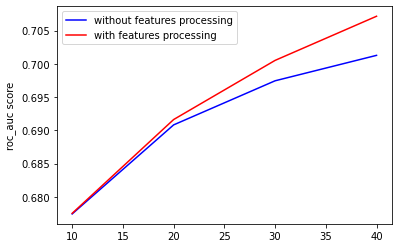

In [16]:
%matplotlib inline

plt.plot(n_est, cvs, 'b', label = 'without features processing')
plt.plot(n_est, CVS, 'r', label = 'with features processing')
plt.ylabel('roc_auc score')
plt.legend()
plt.savefig('roc_auc.png')

<img src="roc_auc.png"> 

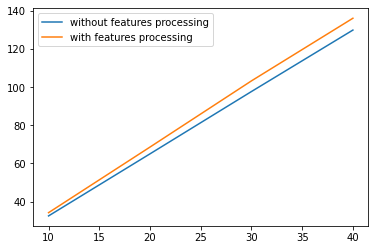

In [14]:
plt.plot(n_est, t, label = 'without features processing')
plt.plot(n_est, T, label = 'with features processing')
plt.legend()
plt.savefig('time')

<img src="time.png"> 

In [9]:
n = 40
GBC = GradientBoostingClassifier(n_estimators=n, verbose=True, random_state=241, learning_rate=0.2)
P = GBC.fit(X, y).predict_proba(xx)

      Iter       Train Loss   Remaining Time 
         1           1.3729           33.13s
         2           1.3633           32.27s
         3           1.3540           31.32s
         4           1.3469           30.26s
         5           1.3393           29.27s
         6           1.3322           28.34s
         7           1.3265           27.46s
         8           1.3205           27.35s
         9           1.3146           26.38s
        10           1.3094           25.45s
        20           1.2753           16.67s
        30           1.2553            8.29s
        40           1.2408            0.00s


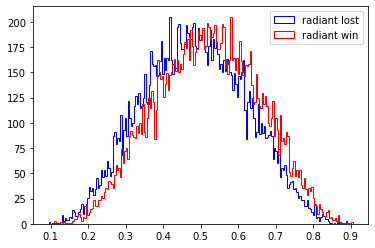

In [15]:
plt.hist(P[:,0], bins = 200, color = 'b', histtype='step', label = 'radiant lost')
plt.hist(P[:,1], bins = 200, color = 'r', histtype='step', label = 'radiant win')
GBC.classes_
plt.legend()
plt.savefig('gbc.png')

<img src="gbc.png"> 